## Pretraining Setup

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
import os
from matplotlib import pyplot as plt 
import cv2
import numpy as np
import scipy.ndimage
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import random
import math
from datetime import datetime

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

In [5]:
class CSRNet(nn.Module):
    def __init__(self, load_pretrained=True):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(pretrained=load_pretrained)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])  # Up to conv4_3

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x


In [6]:
class CrowdDataset(Dataset):
    def __init__(self, image_folder, density_map_folder, image_files, transform=None):
        self.image_folder = image_folder
        self.density_map_folder = density_map_folder
        self.image_files = image_files # Ensure sorted list
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, key):
        if isinstance(key, int):
            idx = key
        elif isinstance(key, str):
            idx = self.image_files.index(key)
            if idx is None:
                raise ValueError(f"Filename {key} not found in dataset.")
        else:
            raise TypeError("Index must be int or str (filename)")

        # Load image
        img_path = self.image_files[idx]
        # print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)
        else:
            image = image.astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1)

        # Load and convert density map
        density_map_name = img_path.replace('.jpg', '_density.npy').replace(self.image_folder, self.density_map_folder)
        density_map = np.load(density_map_name)
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()

        return image, density_map


In [20]:
def get_img_density_filenames(img_folder, density_folder):
    img_paths = []
    heatmap_paths = []
    for file_name in os.listdir(img_folder):
        if file_name.endswith(".jpg"):
            img_paths.append(os.path.join(img_folder, file_name))

    # Iterate over files in Train_density folder
    for file_name in os.listdir(density_folder):
        if file_name.endswith(".npy"):
            heatmap_paths.append(os.path.join(density_folder, file_name))

    print(f"Found {len(img_paths)} images and {len(heatmap_paths)} heatmaps.")
    return img_paths, heatmap_paths

In [ ]:
train_resized_folder = "Train_resized_2"
train_density_folder = "Train_density_2"
validation_resized_folder = "Validation_resized_2"
validation_density_folder = "Validation_density_2"
test_resized_folder = "Test_resized_2"
test_density_folder = "Test_density_2"

print("-----Train-----")
train_image_paths, train_heatmap_paths = get_img_density_filenames(train_resized_folder, train_density_folder)

print("-----Validation-----")
validation_image_paths, validation_heatmap_paths = get_img_density_filenames(validation_resized_folder, validation_density_folder)

print("-----Test-----")
test_image_paths, test_heatmap_paths = get_img_density_filenames(test_resized_folder, test_density_folder)

-----Train-----
Found 4804 images and 4804 heatmaps.
-----Validation-----
Found 668 images and 668 heatmaps.
-----Test-----
Found 668 images and 668 heatmaps.


In [8]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
train_dataset = CrowdDataset(train_resized_folder, train_density_folder, train_image_paths, transform)
validation_dataset = CrowdDataset(validation_resized_folder, validation_density_folder, validation_image_paths, transform)
test_dataset = CrowdDataset(test_resized_folder, test_density_folder, test_image_paths, transform)

In [10]:
def train_model(model, train_loader, val_loader=None, num_epochs=10, lr=1e-5, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # TRAINING
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            # print(outputs.shape, targets.shape)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        print(f"\nEpoch {epoch+1} - Train Loss: {avg_train_loss:.10f}")

        # VALIDATION
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, targets in val_loader:
                    images = images.to(device)
                    targets = targets.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * images.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.10f}")

    return model

## Visualise Output

In [64]:
def visualize_output(model, dataset, device='cuda', index=0, save_dir=None, model_name='tester'):
    model.eval()
    
    # Get a sample
    print(f"Image path is: {train_image_paths[index]}")
    image, gt_density = dataset[index]
    denormalize(image)
    image = image.to(device).unsqueeze(0)  # Add batch dim
    gt_density = gt_density.squeeze().cpu().numpy()

    # Predict
    with torch.no_grad():
        output = model(image)
        output = F.interpolate(output, size=(224, 224), mode='bilinear', align_corners=False)
        output = output.squeeze().cpu().numpy()


    # Count predictions
    actual_count = output.sum()
    gt_count = gt_density.sum()

    # predicted_count = actual_count

    # if actual_count < 0:
    #     predicted_count = 0

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Original image
    axs[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Predicted density map
    axs[1].imshow(output, cmap='jet')
    # axs[1].set_title(f"Predicted Density Map\nCount: {predicted_count:.2f}\nActual Count: {actual_count}")
    axs[1].set_title(f"Predicted Density Map\nPredicted Count: {actual_count}")
    axs[1].axis('off')

    # Ground truth density map
    axs[2].imshow(gt_density, cmap='jet')
    axs[2].set_title(f"Ground Truth Density Map\nCount: {gt_count:.2f}")
    axs[2].axis('off')

    plt.tight_layout()

    # Save if directory is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{model_name}-idx{index}.png")
        plt.savefig(save_path)
        print(f"Saved visualization to: {save_path}")

    plt.show()

def denormalize(tensor_img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor_img * std + mean

## Hyperparams

In [47]:
# Hyperparameter code block: modify this to test your models!
tl_b_size = 30
vl_b_size = 30
epochs = 2
model_lr = 1e-5

## Model Training

In [48]:
device_type = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CSRNet().to(device_type)
print(device_type)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=tl_b_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=vl_b_size, shuffle=False)

cpu


In [49]:
trained_model = train_model(model, train_loader, val_loader, num_epochs=epochs, lr=model_lr, device=device_type)

Epoch 1/2: 100%|██████████| 161/161 [59:38<00:00, 22.23s/it]



Epoch 1 - Train Loss: 0.0005679515
Epoch 1 - Validation Loss: 0.0000482475


Epoch 2/2: 100%|██████████| 161/161 [1:34:32<00:00, 35.23s/it]



Epoch 2 - Train Loss: 0.0000280991
Epoch 2 - Validation Loss: 0.0000257895


## Results

In [50]:
if tl_b_size == vl_b_size:
    model_name = 'b' + str(tl_b_size) + '-lr' + str(int(abs(math.log10(model_lr)))) + '-e' + str(epochs) + '.pth'
else:
    model_name = 'tb' + str(tl_b_size) + '-vb' + str(vl_b_size) + '-lr' + str(abs(math.log10(model_lr))) + '-e' + str(epochs) + '.pth'
model_folder = 'models/'

print(model_folder + model_name)

models/b30-lr5-e2.pth


In [51]:
# Save model
torch.save(trained_model.state_dict(), model_folder + model_name)

Image path is: Train_resized_2\img_0001_crop_1.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


Saved visualization to: results/b30-lr5-e2.pth-idx1.png


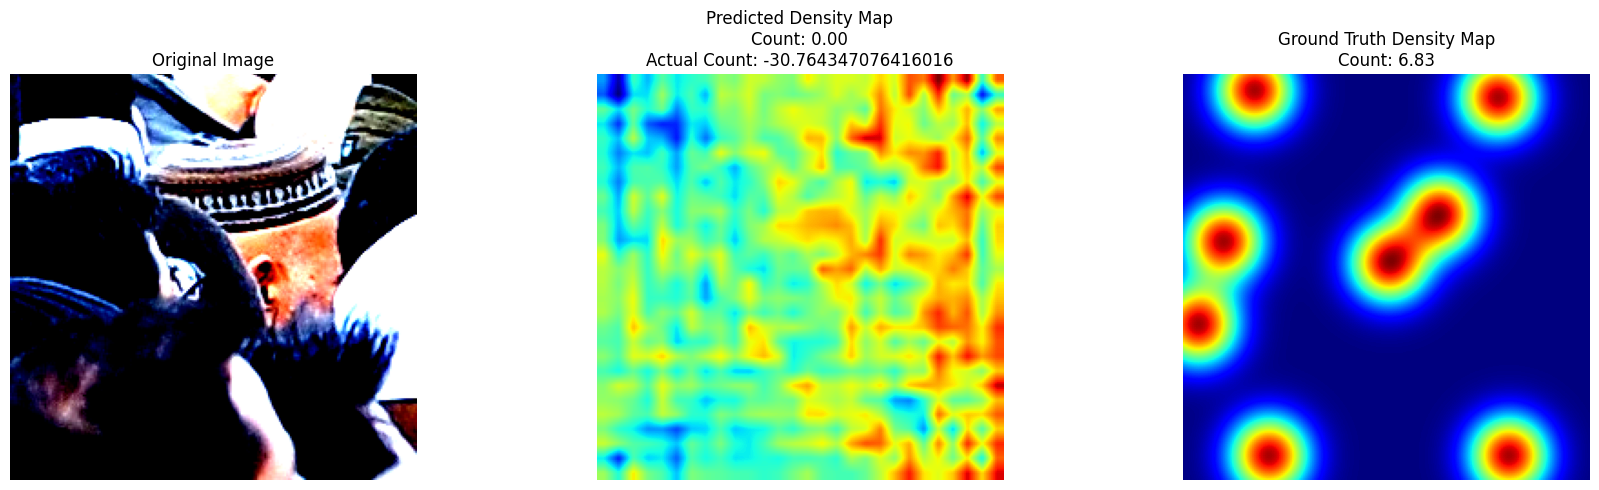

Image path is: Train_resized_2\img_0002_crop_1.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4373858].


Saved visualization to: results/b30-lr5-e2.pth-idx5.png


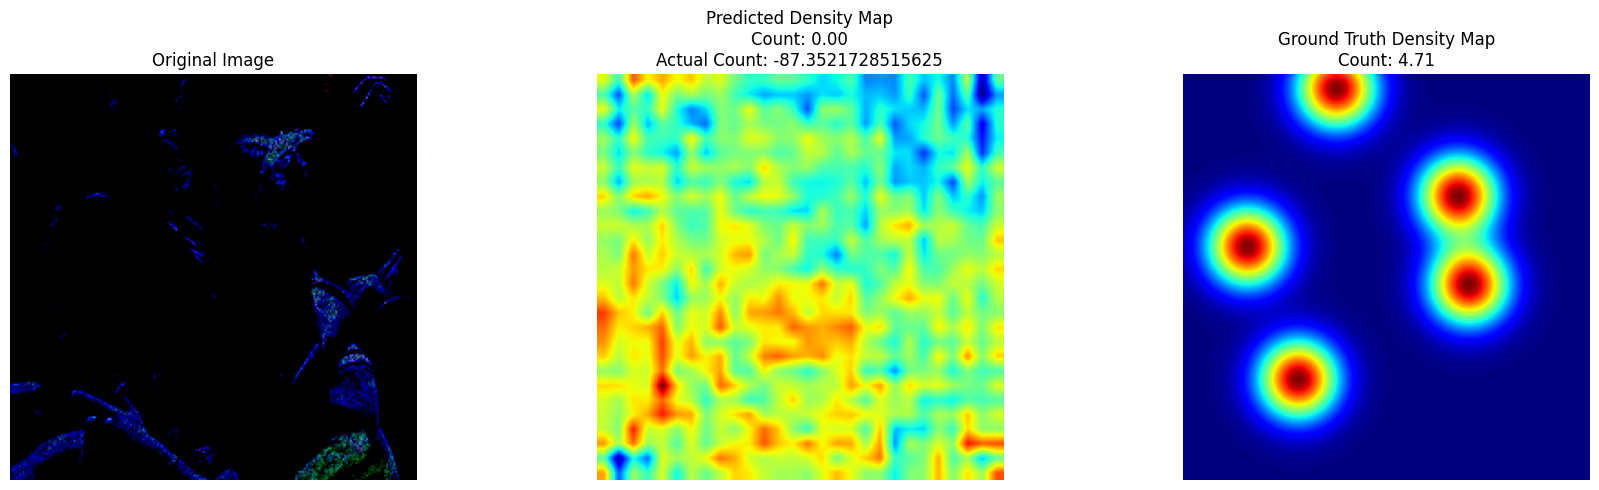

Image path is: Train_resized_2\img_0003_crop_1.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0539435].


Saved visualization to: results/b30-lr5-e2.pth-idx9.png


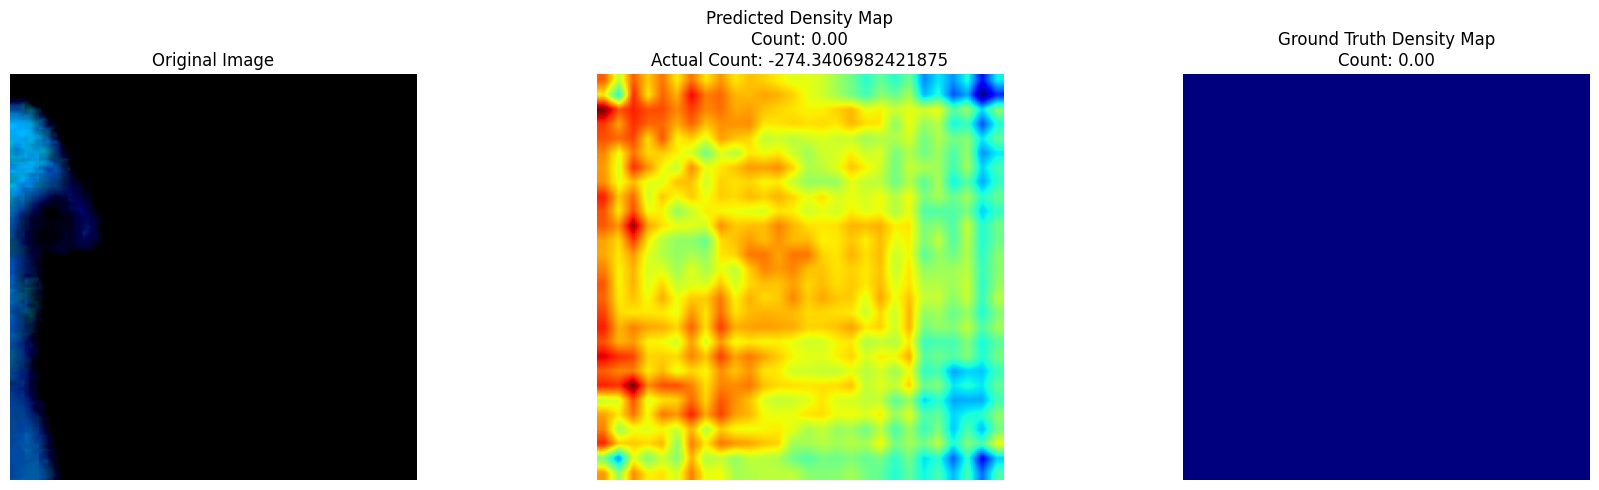

In [58]:
# model = CSRNet()
save_directory = 'results/'
device_type = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_output(trained_model, dataset=train_loader.dataset, index=1, device=device_type, save_dir=save_directory, model_name=model_name)

visualize_output(trained_model, dataset=train_loader.dataset, index=5, device=device_type, save_dir=save_directory, model_name=model_name)

visualize_output(trained_model, dataset=train_loader.dataset, index=9, device=device_type, save_dir=save_directory, model_name=model_name)

### Calculating MAE and other metrics

In [53]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [59]:
# Load saved model
model_name = 'b10-lr5-e3.pth'
trained_model = CSRNet()  # or your model class
trained_model.load_state_dict(torch.load(model_folder + model_name, map_location=torch.device(device_type)))
trained_model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [54]:
def evaluate_model(model, dataloader, device='cuda'):
    model = model.to(device)
    model.eval()
    mae = 0.0
    mse = 0.0

    with torch.no_grad():
        for images, gt_densities in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            gt_densities = gt_densities.to(device)

            outputs = model(images)

            # Resize prediction to match GT size if needed
            if outputs.shape[-2:] != gt_densities.shape[-2:]:
                outputs = F.interpolate(outputs, size=gt_densities.shape[-2:], mode='bilinear', align_corners=False)

            # Count is the sum of the density map
            pred_counts = outputs.sum(dim=[1, 2, 3])
            gt_counts = gt_densities.sum(dim=[1, 2, 3])

            abs_error = torch.abs(pred_counts - gt_counts)
            sq_error = (pred_counts - gt_counts) ** 2

            mae += abs_error.sum().item()
            mse += sq_error.sum().item()

    total_samples = len(dataloader.dataset)
    mae /= total_samples
    mse /= total_samples
    rmse = mse ** 0.5

    print(f"\nEvaluation Results:")
    print(f"MAE  (Mean Absolute Error): {mae:.2f}")
    print(f"MSE  (Mean Squared Error):  {mse:.2f}")
    print(f"RMSE (Root Mean Squared):   {rmse:.2f}")

    os.makedirs('models', exist_ok=True)
    log_path = os.path.join('models', 'results.txt')
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_path, 'a') as f:
        f.write(f"\n\n[{timestamp}]\n{model_name} Evaluation:\n")
        f.write(f"  MAE:  {mae:.2f}\n")
        f.write(f"  MSE:  {mse:.2f}\n")
        f.write(f"  RMSE: {rmse:.2f}")


    return mae, mse, rmse

mae, mse, rmse = evaluate_model(trained_model, test_loader, device=device_type)

Evaluating: 100%|██████████| 668/668 [04:30<00:00,  2.47it/s]


Evaluation Results:
MAE  (Mean Absolute Error): 125.52
MSE  (Mean Squared Error):  26480.45
RMSE (Root Mean Squared):   162.73


Image path is: Train_resized_2\img_0001_crop_0.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.2216995].


Saved visualization to: results/b10-lr5-e3.pth-idx0.png


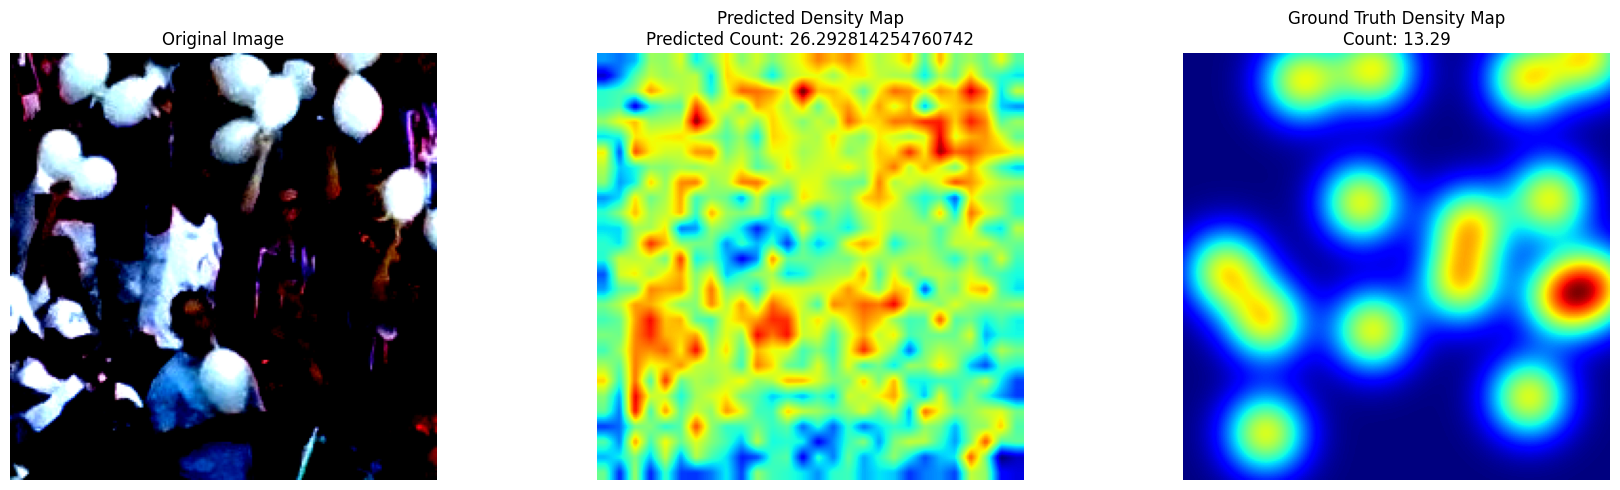

Image path is: Train_resized_2\img_0001_crop_2.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Saved visualization to: results/b10-lr5-e3.pth-idx2.png


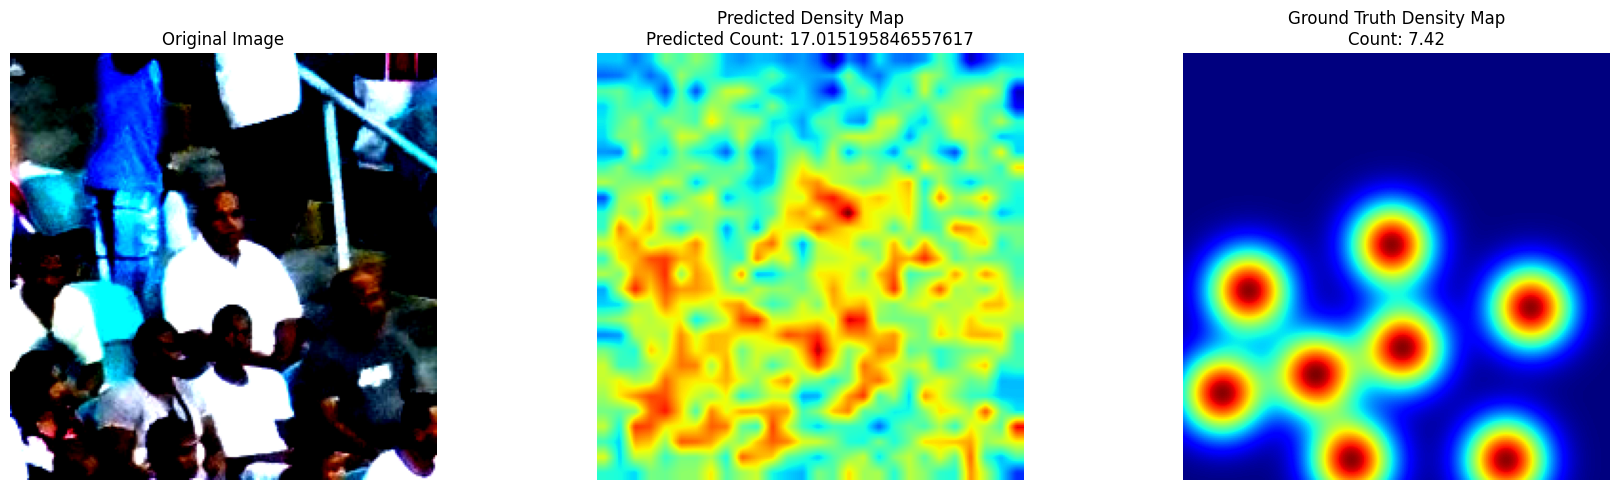

Image path is: Train_resized_2\img_0002_crop_3.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Saved visualization to: results/b10-lr5-e3.pth-idx7.png


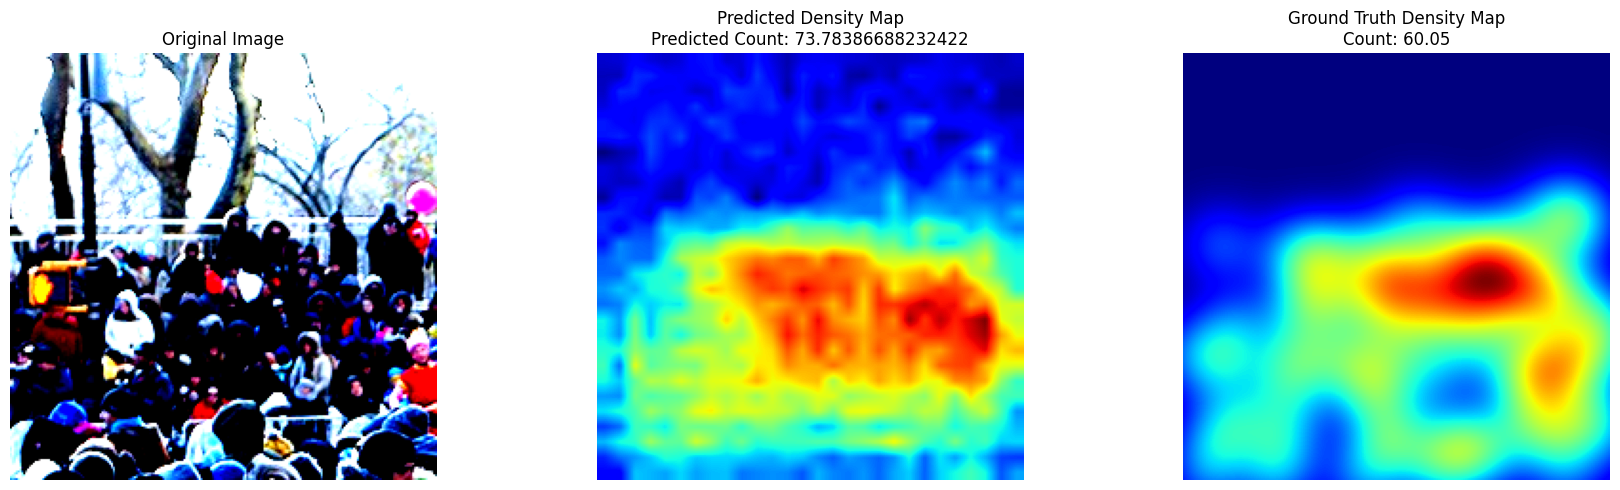

In [65]:
visualize_output(trained_model, dataset=test_loader.dataset, index=0, device=device_type, save_dir=save_directory, model_name=model_name)
visualize_output(trained_model, dataset=test_loader.dataset, index=2, device=device_type, save_dir=save_directory, model_name=model_name)
visualize_output(trained_model, dataset=test_loader.dataset, index=7, device=device_type, save_dir=save_directory, model_name=model_name)

In [ ]:
gt_density = np.load("Train_density_2/img_0001_crop_0_density.npy")  # Load a sample density map
gt_density_fixed = gt_density.sum() 
print(f"GT Density Map Count: {gt_density_fixed:.2f}")  

GT Density Map Count: 9.92
